# Math/Data Question—Provo City Water Filtration

You are a civil engineer for the city of Provo tasked with monitoring the concentration of algal toxins in the drinking water. Your water filtration system consists of two tanks, a treatment tank and a reservoir tank.
1. The treatment tank is constantly filled with lake water at $50\ L/m$. The reservoir tank is filled with spring water at a rate of $\mathfrak{R}=50 + 50\sin(t)\ L/m$. The treatment tank is pumped into the reservoir tank at $100\ L/m$ and the reservoir tank is pumped into the treatment tank at $50\ L/m$. The reservoir tank supplies the city at $100\ L/m$.

    Utah lake is known to contain $1$ gram of algal toxins per liter of water, while the spring water from Rock Canyon has no algal toxins in it. If you fill the treatment tank with $1000$ liters of lake water and fill the reservoir tank with $300$ liters of spring water and turn the system on, how many grams of algal toxin would have to be removed from the treatment tank each minute to keep the concentration of toxins in the drinking water under $0.5\ g/L$ after the system stabilizes?

The following image shows this situation, with arrows indicating the direction of the flow of water and the amount of water flowing.
We use the following notations:
- $A_1(t)$: The *amount* of toxin in tank 1 (treatment tank) at time $t$.
- $A_2(t)$: The amount of toxin in tank 2 (reservoir) at time $t$.
- $V_1(t)$: The volume of water in tank 1 at time $t$.
- $V_2(t)$: The volume of water in tank 2 at time $t$.
- $C_1(t) = A_1(t)/V_1(t)$: The concentration of toxin in tank 1 at time $t$.
- $C_2(t) = A_2(t)/V_2(t)$: The concentration of toxin in tank 2 at time $t$.

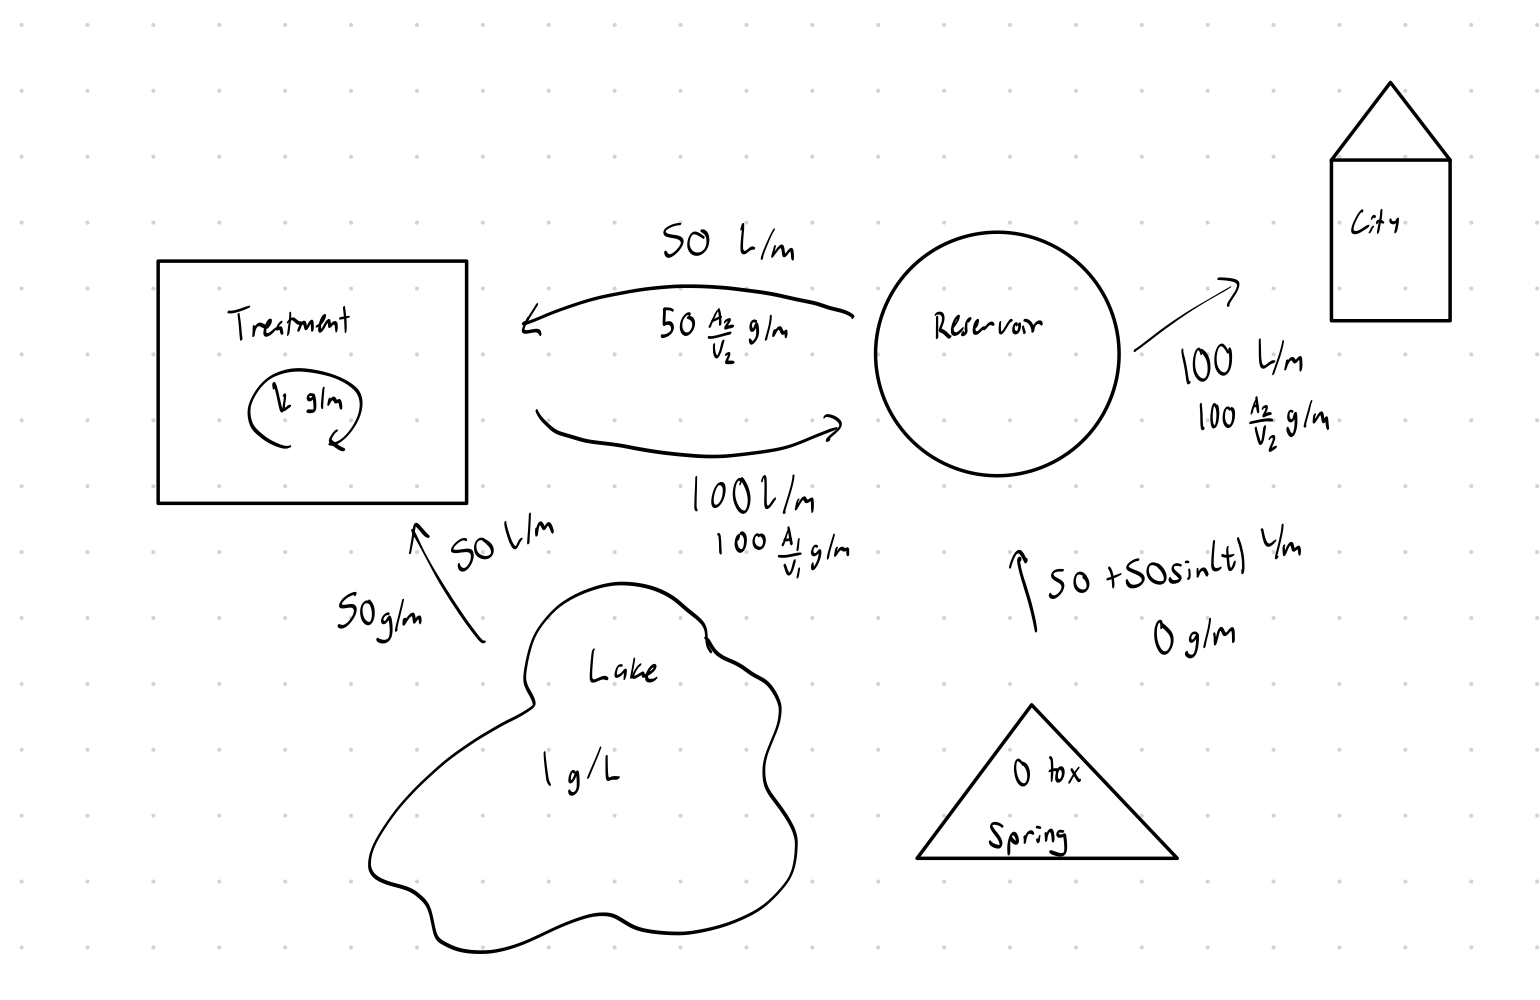

The volume of the treatment tank is constant, given by
$$
V_{1}(t) = 1000,
$$
while the volume of the reservoir tank is 
$$
V_{2}(t) = 300 + 50\sin(t). 
$$
We want to identify the smallest value $k$ of grams of toxin that must be removed each minute in order to keep the toxin levels below $0.5\ g/L$ in the steady state.
The amount (not concentration) of toxins in each tank is described by the ODE system
$$
\begin{align*}
    A_1' &= 50 - 100 C_1 + 50 C_2 - k \\
    A_2' &= 100 C_1 - 150 C_2, \\
    A_1(0) &= 1000, A_2(0) = 0
\end{align*}
$$
which can be represented as the matrix equation
$$
\begin{align}
    \begin{bmatrix*} A_1 \\ A_2 \end{bmatrix*}' &=
    \begin{bmatrix*} -100 & 50 \\ 100 & -150 \end{bmatrix*}\begin{bmatrix*} C_1 \\ C_2 \end{bmatrix*} + \begin{bmatrix*} 50 - k\\ 0 \end{bmatrix*}, \\
    A(0) &= \begin{bmatrix*} 1000 \\ 0 \end{bmatrix*}.
\end{align}
$$
Below, we plot a numerical solution to $(1)$ and $(2)$ with $k = 0$, assuming that the tank is filtering none of the algae.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

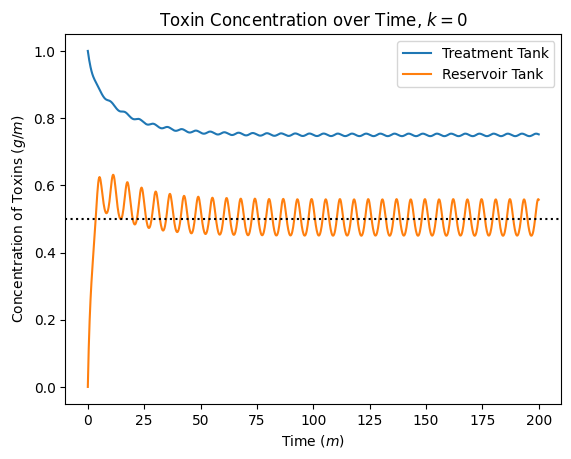

In [2]:
# Define transition matrix for amount of bacteria
B = np.array([
    [-100, 50],
    [100, -150]
])

# Function for the volume in each time at time t
def V(t):
    return np.array([
        1000 * np.ones_like(t),
        300 + 50 * np.cos(t)
    ])
V2 = lambda t: 300 + 50 * np.sin(t)

# Define the ODE system
def ode(t, y, k):

    return B @ (y / V(t)) + np.array([50 - k[0], 0])

# Initial condition
x0 = np.array([1000, 0])

t_span = (0, 200)
t_eval = np.linspace(*t_span, 1000)

# Solve the ODE system to determine the amount of bacteria in each tank
sol = solve_ivp(ode, t_span, x0, t_eval=t_eval, args=([0],))
y = sol.y
A1, A2 = sol.y

# Calculate the volume in each tank
V1 = 1000 * np.ones_like(t_eval)


# Calculates the concentration in each tank
C1 = A1 / V1
C2 = A2 / V2(t_eval)

# Plot the resulting concentrations
plt.plot(t_eval, C1, label="Treatment Tank")
plt.plot(t_eval, C2, label="Reservoir Tank")
plt.axhline(0.5, linestyle='dotted', color='black')

plt.legend()
plt.xlabel("Time ($m$)")
plt.ylabel("Concentration of Toxins ($g/m$)")
plt.title(f"Toxin Concentration over Time, $k={0}$")
plt.show()


As you can see, the concentration of toxins in the water frequently rises above $0.5$.
To solve this, we choose to minimize the squared difference between the largest value in the reservoir concentration after $100$ seconds, giving sufficient time for the system to stabilize.

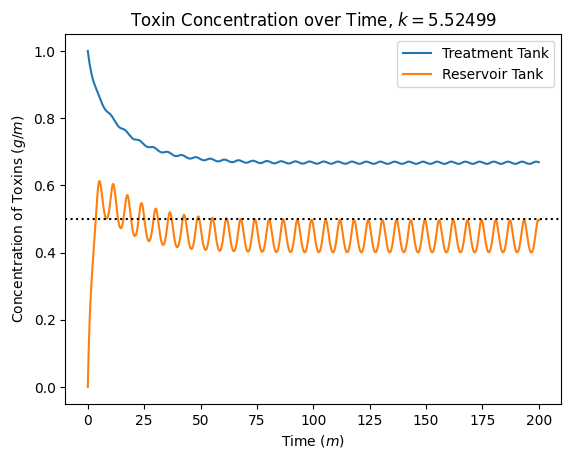

In [3]:
# Function to minimize
def f(k, n=500):
    sol = solve_ivp(ode, t_span, x0, t_eval=t_eval, args=(k,))
    A2 = sol.y[1, 1000-n:]
    C2 = A2 / V2(np.linspace(200 - (n / 5), 200, n))
    return (C2.max() - 0.5)**2

k0 = 1
k = minimize(f, k0).x


# Solve the ODE system to determine the amount of bacteria in each tank
sol = solve_ivp(ode, t_span, x0, t_eval=t_eval, args=(k,))
y = sol.y
A1, A2 = sol.y

# Calculate the volume in each tank
V1 = 1000 * np.ones_like(t_eval)


# Calculates the concentration in each tank
C1 = A1 / V1
C2 = A2 / V2(t_eval)

# Plot the resulting concentrations
plt.plot(t_eval, C1, label="Treatment Tank")
plt.plot(t_eval, C2, label="Reservoir Tank")
plt.axhline(0.5, linestyle='dotted', color='black')

plt.legend()
plt.xlabel("Time ($m$)")
plt.ylabel("Concentration of Toxins ($g/m$)")
plt.title(f"Toxin Concentration over Time, $k={float(k):.5f}$")
plt.show()

As shown above, we require the treatment tank to remove $5.52499$ grams of toxin per minute in order to keep the steady-state maximum level of toxicity below $0.5\ g/L$.

Two primary changes occurred in the system:
1) Not enough water making it to the residents, and
2) Lower concentration of algae in the reservoir.

I would first examine the pump, then the treatment location, and then the individual pipes.

I wouldn't check the treatment location first because the lower concentration of algae indicates that there is not more algae getting through.
This might be because the filter is doing much better, or because the water is not getting into the reservoir from the treatment plant. 
The first case is not very likely, and if it were the case, then we likely would see an increase in water getting to residents, not a decrease.
Therefore, the second case is more likely, and the source of the issue would most likely be the pump between the two tanks, because an issue in the piping wouldn't have inflenced the concentration of algae, so checking individual pipes won't help identify the issue.
Therefore, the best place to check first is the pump.

Next, assuming that the pump is working alright, the reason I would check the treatment location before the individual pipes is because an issue with the pipes wouldn't have affected the concentration of algae in the reservoir.
Only the treatment location could influence how much algae is getting through, so this would be the next logical place to check for issues.

This leaves only the individual pipes, which I don't expect are the issue.
I would guess that the pumps really are the issue, and perhaps something with the treatment location if the pumps are working well.